# Knowledge Graph
Attempting to build a knowledge graph to visualizer realtionships between words

In [1]:
import pandas as pd
import spacy
from tqdm import tqdm
import warnings
from spacy.matcher import Matcher 
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Load Spacy NLP Library
The language data is specifically in English so we'll use the english core module in Spacy. 

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
df = pd.read_csv('../data/data.csv', encoding="latin-1")
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


# Language data preprocessing
The get language data function extracts all the notes sections from each terrorist attack that has occured. To isolate topics, a filter for the attack type is added. Using the filter we can grab language data associated with a certain attack type like bombings/fires etc. 

In [4]:
def get_language_data(dataframe, column_filter):
    df = dataframe[dataframe["attacktype1_txt"] == column_filter]
    my_data = pd.DataFrame(df, columns=['attacktype1_txt', 'addnotes']).dropna()
    return my_data

# Building paragraphs
Knowledge graphs work better when having multiple sentences to work with. We'll create a function that combines each sentence into one large paragraph. 

In [5]:
def sentence_concatination(df):
    sent = ""
    for item in df["addnotes"]:
        sent += item
    return sent

Example of using the language data function to grab language data related to bombings and explosions. 

In [6]:
data = get_language_data(df, "Bombing/Explosion")
data = data.head(10)

In [7]:
sentence = sentence_concatination(data)
sentence

'Damages were estimated to be between $20,000-$25,000.One half hour after the bomb explosion, an anonymous caller warned of a bomb that was going to detonated in the locker room, however this device was never found.  The inscriptions on the wall of the building were "Panthers 21," "Support Young Lords," and "Americong."  There was no history of racial violence at James Madison High School.Witnesses observed three African American males running from the scene.Judith and Silas Bissell were both members of Students for a Democratic Society.This attack might be linked with other episodes of strike violence in South City Nebraska (197001300001, 197001300002, 197002230001, 197002230002, 197002230003, 197002230004)Police, at the time, suspected that this attack was linked to dissatisfaction over integration of the schools.  John Thomas, John Buffington, and three other Blacks were charged with conspiracy but no individual was indicted.This incident might be part of a multiple attack with 1970

## Extract subjects from sentence
Using the SPACY library, we can extract parts of sentences like punctuation, subjects and verbs. 

document = nlp(sentence)
for tok in document:
    print(tok.text, "....", tok.dep_)

# Entity Extraction
Using this function we'll filter for certain punctuation rules and extract sentences in this order.
Noun -> Descriptive value (Cardinal) -> Subjects

In [9]:
def get_entities(sent):
    
    # first chunk
    ent1 = ""
    ent2 = ""
    
    prv_tok_dep = ""
    prv_tok_text = ""
    
    prefix = ""
    modifier = ""
    
    for tok in nlp(sent):
        # second chunk
        if tok.dep_ != "punct":
            # check if token is compound or not
            if tok.dep_ == "compound":
                prefix = tok.text
                
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text
                    
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word is also a compound
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text
            
            # chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
                
            # Chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text
                
            # chunk 5
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
            
    return [ent1.strip(), ent2.strip()]
    

# Example output
This is an example input of how the entity extraction algorithm should work. 

In [10]:
results = get_entities("the film had 200 patents")
results

['film', '200  patents']

In [20]:
entity_pairs = []

for i in tqdm(data["addnotes"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 10/10 [00:00<00:00, 98.17it/s]


In [12]:
entity_pairs

[['Damages', '$  20,000-$25,000'],
 ['inscriptions', 'racial Madison High School'],
 ['Witnesses', 'American  scene'],
 ['Judith', 'Democratic Society'],
 ['attack', 'other South City Nebraska'],
 ['other John individual', 'other John conspiracy'],
 ['Also  attack', 'other South City Nebraska'],
 ['Also  attack', 'other South City Nebraska'],
 ['attack', 'other Beef Packers strike'],
 ['however  perpetrators', 'shortly  explosion']]

# Extracting relationships
Using the get realation function to see how a noun is related to another subject. 

In [13]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern], on_match=None) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [14]:
result = get_relation("John completed the task")
result

'completed'

In [15]:
relations = [get_relation(i) for i in tqdm(data["addnotes"])]
relations

100%|██████████| 10/10 [00:00<00:00, 93.06it/s]


['estimated',
 'was',
 'observed',
 'were',
 'linked with other',
 'charged with',
 'linked with other',
 'linked with other',
 'linked with other',
 'apprehended']

In [16]:
pd.Series(relations).value_counts()[:50]

linked with other    4
estimated            1
was                  1
observed             1
were                 1
charged with         1
apprehended          1
dtype: int64

# Building the knowledge graph

In [17]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [18]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

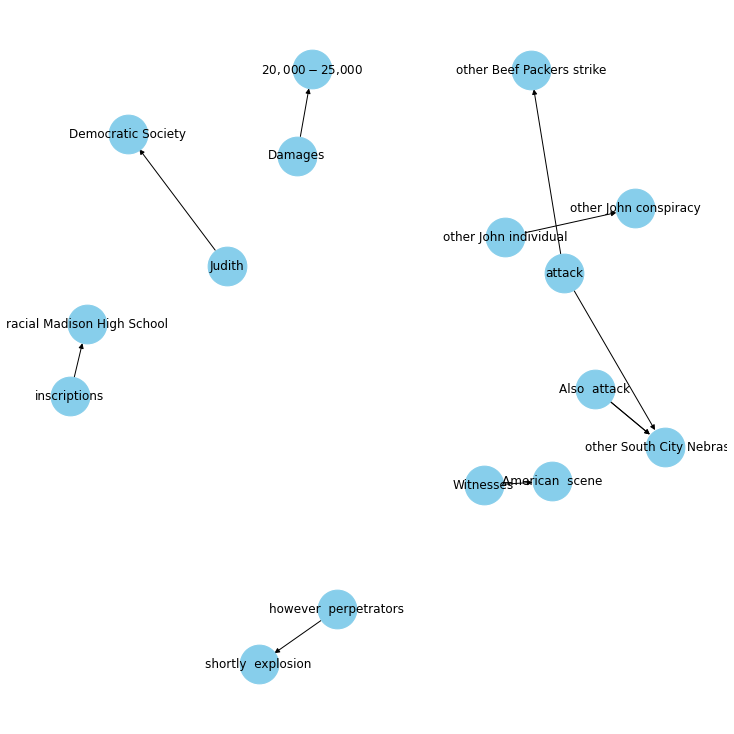

In [22]:
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G, k=0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()